In [1]:
import modelframe as mf
import models as ms
import numpy as np
import torch
import matplotlib.pyplot as plt

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import os

import plotutilities as pu
import datautilities as du

### Binary Network
Uses a binary classification: the signal corresponds to a gravitational wave or a "glitch" which originates from other cosmic events or noise.

In [2]:
binary_model_directory = "../model/model-binary-weighted-001"

binary_features, binary_labels = du.read_in_data("../data/dataset_all_H1_bootstrap_O3a.npy", {0:0,1:1,2:1,3:1,4:1,5:1,6:1})

os.makedirs(f"{binary_model_directory}/figures", exist_ok=True)

def run_binary_network_weighted():
    

   

    binary_model = ms.GlitchClassifier(6, 32, 2)

    binary_frame = mf.GlitchModel(binary_model, binary_features, binary_labels, device = 'cuda')
    binary_frame.number_of_epochs = 250
    binary_frame.learning_rate = 0.00001
    binary_frame.setup(256)
    binary_frame.train()
    binary_frame.test_model()
    binary_frame.save_model(binary_model_directory, name = "model.pt")
    
    
    
    return binary_frame
    

In [3]:
binary_frame_1 = run_binary_network_weighted()
# torch.cuda.empty_cache()


'100%'

'Epoch 250/250, Train Loss: 0.5068, Val Loss: 0.5268, Precision: 0.3353, Recall: 0.8653, Accuracy: 0.7421'

Train time: 75.14595913887024


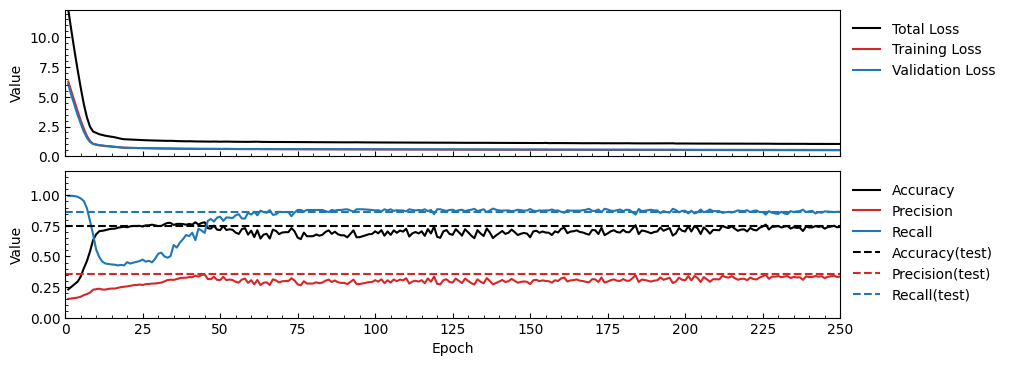

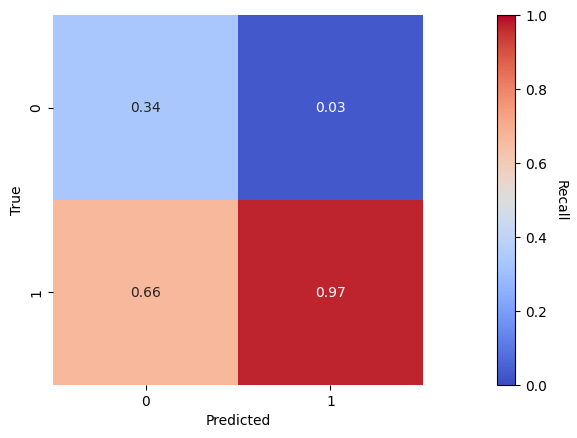

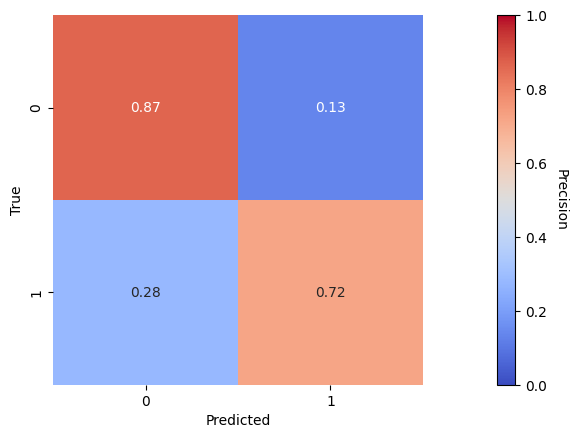

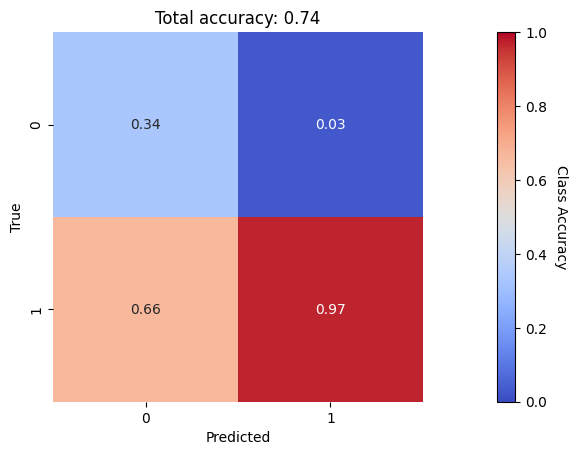

In [8]:
fig,ax = pu.plot_performance(binary_frame_1)
fig.savefig(f"{binary_model_directory}/figures/performance-overview-1.pdf", bbox_inches = "tight")
fig.savefig(f"{binary_model_directory}/figures/performance-overview-1.png", bbox_inches = "tight")

fig, ax = pu.plot_recall_matrix(binary_frame_1)
fig.savefig(f"{binary_model_directory}/figures/recall-matrix-1.pdf", bbox_inches = "tight")
fig.savefig(f"{binary_model_directory}/figures/recall-matrix-1.png", bbox_inches = "tight")

fig, ax = pu.plot_precision_matrix(binary_frame_1)
fig.savefig(f"{binary_model_directory}/figures/precision-matrix-1.pdf", bbox_inches = "tight")
fig.savefig(f"{binary_model_directory}/figures/precision-matrix-1.png", bbox_inches = "tight")

fig, ax = pu.plot_accuracy_matrix(binary_frame_1)
fig.savefig(f"{binary_model_directory}/figures/accuracy-matrix-1.pdf", bbox_inches = "tight")
fig.savefig(f"{binary_model_directory}/figures/accuracy-matrix-1.png", bbox_inches = "tight")


### Underfitting Binary Network

In [5]:
binary_model_directory = "../model/model-binary-undersampled-001"

binary_features, binary_labels = du.read_in_data("../data/dataset_all_H1_bootstrap_O3a.npy", {0:0,1:1,2:1,3:1,4:1,5:1,6:1})

os.makedirs(f"{binary_model_directory}/figures", exist_ok=True)

def run_binary_network_undersampled():
    

   

    binary_model = ms.GlitchClassifier(6, 32, 2)

    binary_frame = mf.GlitchModel(binary_model, binary_features, binary_labels, device = 'cuda')
    binary_frame.number_of_epochs = 250
    binary_frame.learning_rate = 0.00001
    binary_frame.setup(256)
    binary_frame.train(True)
    binary_frame.test_model()
    binary_frame.save_model(binary_model_directory, name = "model.pt")
    
    
    
    return binary_frame
    

In [6]:
binary_frame_2 = run_binary_network_undersampled()



'100%'

'Epoch 250/250, Train Loss: 0.3186, Val Loss: 0.7718, Precision: 0.1730, Recall: 0.9862, Accuracy: 0.3635'

Train time: 76.78110814094543


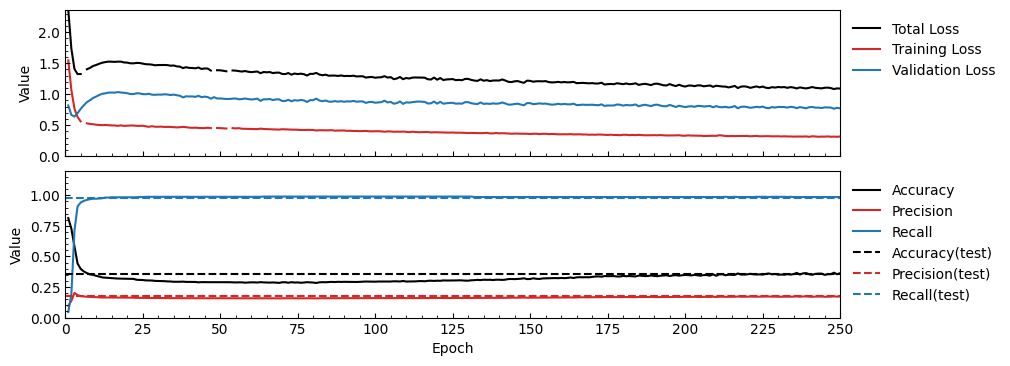

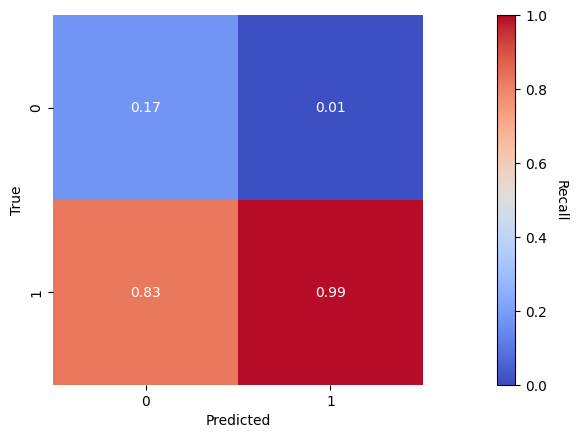

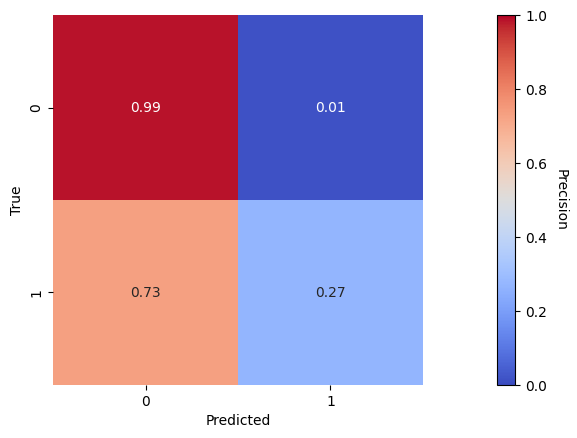

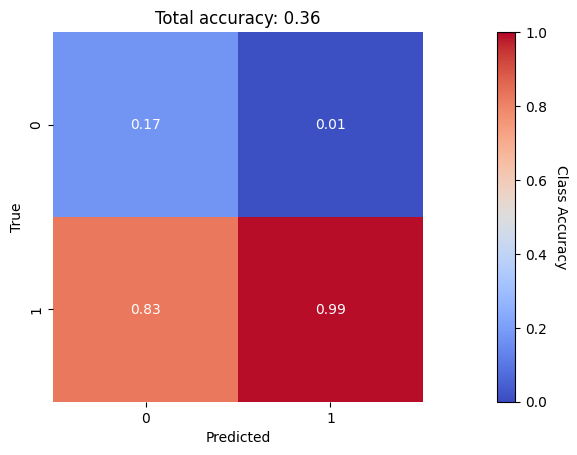

In [7]:
fig,ax = pu.plot_performance(binary_frame_2)
fig.savefig(f"{binary_model_directory}/figures/performance-overview-1.pdf", bbox_inches = "tight")
fig.savefig(f"{binary_model_directory}/figures/performance-overview-1.png", bbox_inches = "tight")

fig, ax = pu.plot_recall_matrix(binary_frame_2)
fig.savefig(f"{binary_model_directory}/figures/recall-matrix-1.pdf", bbox_inches = "tight")
fig.savefig(f"{binary_model_directory}/figures/recall-matrix-1.png", bbox_inches = "tight")

fig, ax = pu.plot_precision_matrix(binary_frame_2)
fig.savefig(f"{binary_model_directory}/figures/precision-matrix-1.pdf", bbox_inches = "tight")
fig.savefig(f"{binary_model_directory}/figures/precision-matrix-1.png", bbox_inches = "tight")

fig, ax = pu.plot_accuracy_matrix(binary_frame_2)
fig.savefig(f"{binary_model_directory}/figures/accuracy-matrix-1.pdf", bbox_inches = "tight")
fig.savefig(f"{binary_model_directory}/figures/accuracy-matrix-1.png", bbox_inches = "tight")
